In [1]:
library(dplyr)
library(ggplot2)
library(lubridate)
library(reshape2)
library(h2o)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:lubridate’:

    day, hour, month, week, year


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.nume

In [2]:
sales_train <- read.csv("./dataset/sales_train.csv")
test <- read.csv("./dataset/test.csv")
items <- read.csv("./dataset/items.csv")
item_categories <- read.csv("./dataset/item_categories.csv")
shops <- read.csv("./dataset/shops.csv")

# 1. Data Cleaning and Preprocessing

## 1.1 Loading and cleaning data

In [3]:
sales_train_data <- merge(sales_train,items,by="item_id",all.x=TRUE)
sales_train_data <- merge(sales_train_data,shops,by="shop_id",all.x=TRUE)

In [4]:
cbind(colSums(is.na(sales_train_data)))

shop_id,0
item_id,0
date,0
date_block_num,0
item_price,0
item_cnt_day,0
item_name,0
item_category_id,0
shop_name,0


## 1.2 Formatting the data

In [5]:
sales_train$date <- as.Date(sales_train$date,format="%d.%m.%Y")

sales_train$month <- lubridate::month(sales_train$date)
sales_train$year <- lubridate::year(sales_train$date)
sales_train$day <- lubridate::day(sales_train$date)

# sales_train$month <- format(sales_train$date,"%m")
# sales_train$year <- format(sales_train$date,"%Y")
# sales_train$date <- format(sales_train$date,"%d")

## 1.3 Grouping the data

In [6]:
monthly_sales <- sales_train %>%
    group_by(year,month,day,shop_id,item_id,item_cnt_day,item_price) %>%
    summarise(total_sales = sum(item_cnt_day*item_price))

`summarise()` has grouped output by 'year', 'month', 'day', 'shop_id', 'item_id', 'item_cnt_day'.
You can override using the `.groups` argument.


## 1.4 Data Analysis
###  > Outliers

In [7]:
nrow(monthly_sales)

[1] 2935843

In [8]:
glimpse(monthly_sales)

Rows: 2,935,843
Columns: 8
Groups: year, month, day, shop_id, item_id, item_cnt_day [2,935,825]
$ year         <dbl> 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 201…
$ month        <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ day          <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ shop_id      <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ item_id      <int> 991, 1472, 1905, 2920, 3320, 4464, 4724, 5649, 6911, 6916…
$ item_cnt_day <dbl> 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ item_price   <dbl> 99.0, 2599.0, 249.0, 599.0, 1999.0, 599.0, 1399.0, 2190.0…
$ total_sales  <dbl> 99.0, 2599.0, 249.0, 1198.0, 1999.0, 599.0, 1399.0, 2190.…


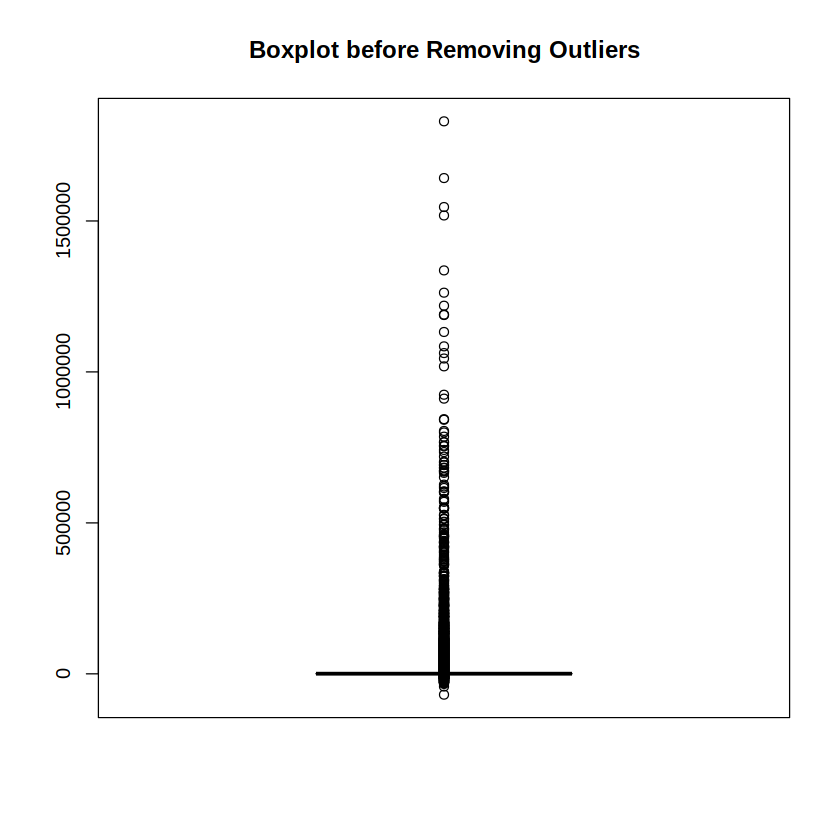

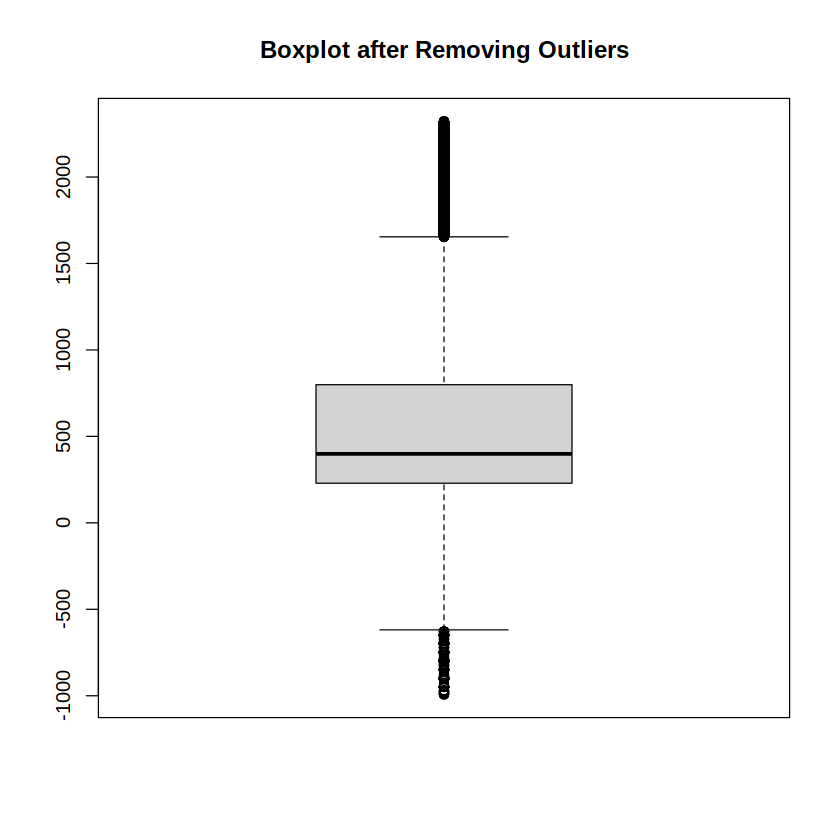

In [9]:
Q1 <- quantile(monthly_sales$total_sales, 0.25)
Q3 <- quantile(monthly_sales$total_sales, 0.75)
IQR <- Q3 - Q1

threshold <- 1.5 * IQR

outliers <- monthly_sales$total_sales < (Q1 - threshold) | monthly_sales$total_sales > (Q3 + threshold)
cleaned_dataset <- monthly_sales[!outliers, ]
# cleaned_dataset <- cleaned_dataset[cleaned_dataset$total_sales >=0,]
boxplot(monthly_sales$total_sales, main = "Boxplot before Removing Outliers")

boxplot(cleaned_dataset$total_sales, main = "Boxplot after Removing Outliers")

# 2. Exploratory Data Analysis (EDA)

In [10]:
#cleaned_dataset$month <- as.factor(cleaned_dataset$month)
glimpse(cleaned_dataset)

Rows: 2,638,592
Columns: 8
Groups: year, month, day, shop_id, item_id, item_cnt_day [2,638,574]
$ year         <dbl> 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 201…
$ month        <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ day          <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ shop_id      <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ item_id      <int> 991, 1905, 2920, 3320, 4464, 4724, 5649, 6911, 6916, 8665…
$ item_cnt_day <dbl> 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ item_price   <dbl> 99.0, 249.0, 599.0, 1999.0, 599.0, 1399.0, 2190.0, 599.0,…
$ total_sales  <dbl> 99.0, 249.0, 1198.0, 1999.0, 599.0, 1399.0, 2190.0, 599.0…


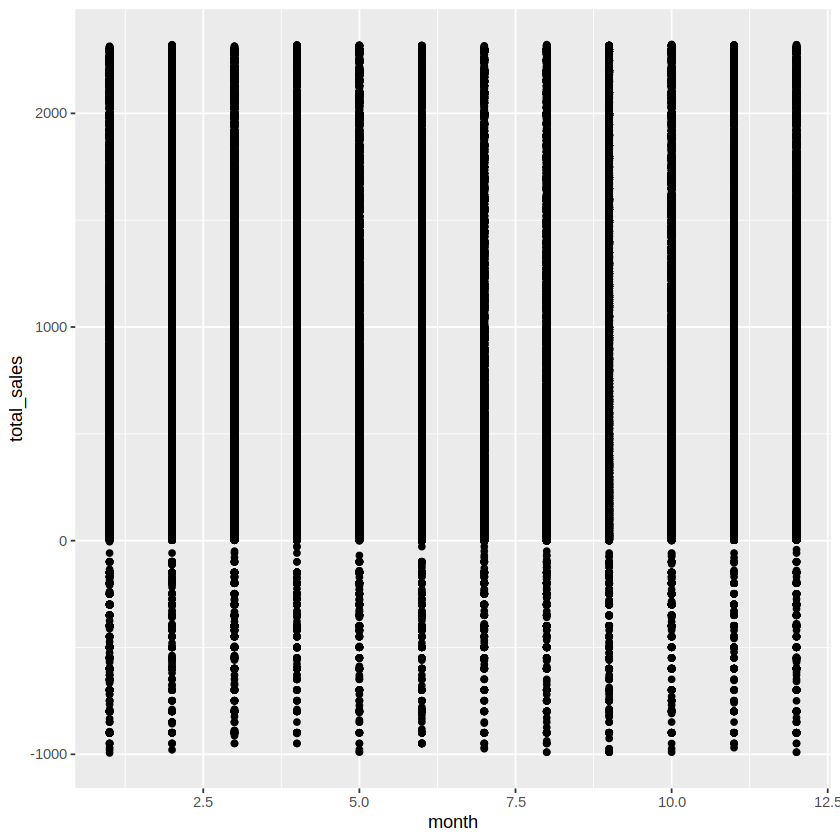

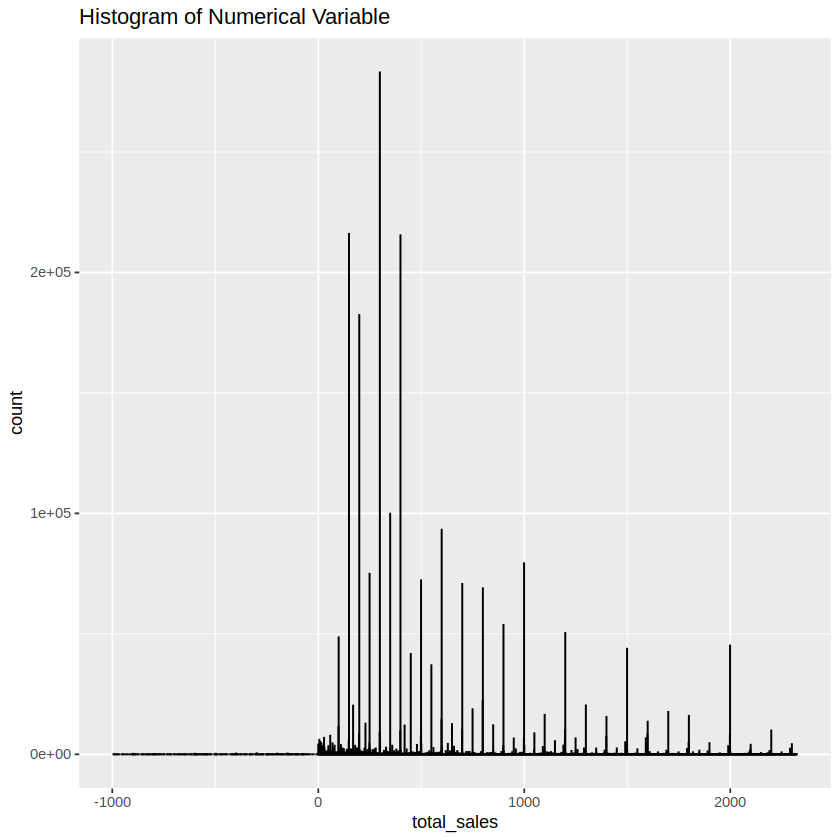

In [11]:
ggplot(cleaned_dataset, aes(x = month, y = total_sales)) +
  geom_point()

ggplot(cleaned_dataset, aes(x = total_sales)) +
  geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
  labs(title = "Histogram of Numerical Variable")

In [12]:
cleaned_dataset$total_sales <- as.integer(cleaned_dataset$total_sales)
cleaned_dataset$year <- as.integer(cleaned_dataset$year)
cleaned_dataset$month <- as.integer(cleaned_dataset$month)
cleaned_dataset$day <- as.integer(cleaned_dataset$day)
selected_columns <- c("total_sales", "shop_id", "item_id","year", "month", "day","item_cnt_day")
subset_data <- cleaned_dataset %>% select(all_of(selected_columns))
head(subset_data)

total_sales,shop_id,item_id,year,month,day,item_cnt_day
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
99,2,991,2013,1,1,1
249,2,1905,2013,1,1,1
1198,2,2920,2013,1,1,2
1999,2,3320,2013,1,1,1
599,2,4464,2013,1,1,1
1399,2,4724,2013,1,1,1


## 2.1 Correlation 

In [13]:
correlation_matrix <- cor(subset_data)
print(correlation_matrix)

              total_sales      shop_id      item_id         year       month
total_sales   1.000000000 -0.033204186 -0.240112146  0.083598378  0.02909994
shop_id      -0.033204186  1.000000000  0.027668105  0.015517008  0.02546557
item_id      -0.240112146  0.027668105  1.000000000  0.023899917  0.01032206
year          0.083598378  0.015517008  0.023899917  1.000000000 -0.12910248
month         0.029099941  0.025465568  0.010322062 -0.129102483  1.00000000
day           0.008608964  0.000363224  0.000818515 -0.014375332  0.08673711
item_cnt_day  0.019030416  0.001436620  0.053763706 -0.001594517  0.01086544
                      day item_cnt_day
total_sales   0.008608964  0.019030416
shop_id       0.000363224  0.001436620
item_id       0.000818515  0.053763706
year         -0.014375332 -0.001594517
month         0.086737112  0.010865441
day           1.000000000  0.002514523
item_cnt_day  0.002514523  1.000000000


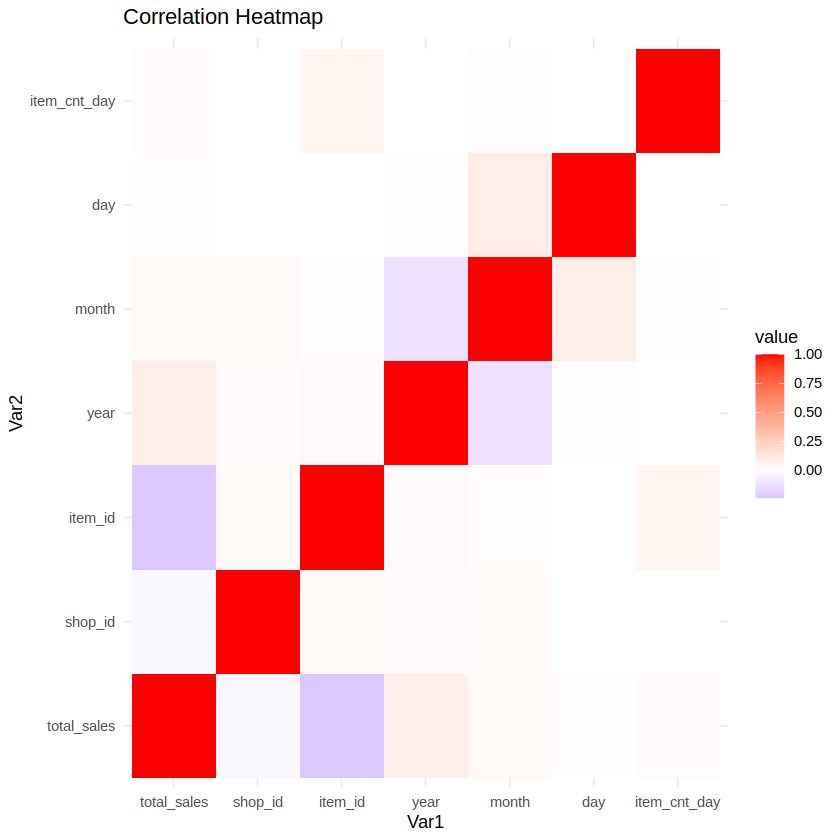

In [14]:
ggplot(data = melt(correlation_matrix), aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  labs(title = "Correlation Heatmap")

## 2.2 Missing Values

In [15]:
na_count <- colSums(is.na(cleaned_dataset))
print(na_count)

        year        month          day      shop_id      item_id item_cnt_day 
           0            0            0            0            0            0 
  item_price  total_sales 
           0            0 


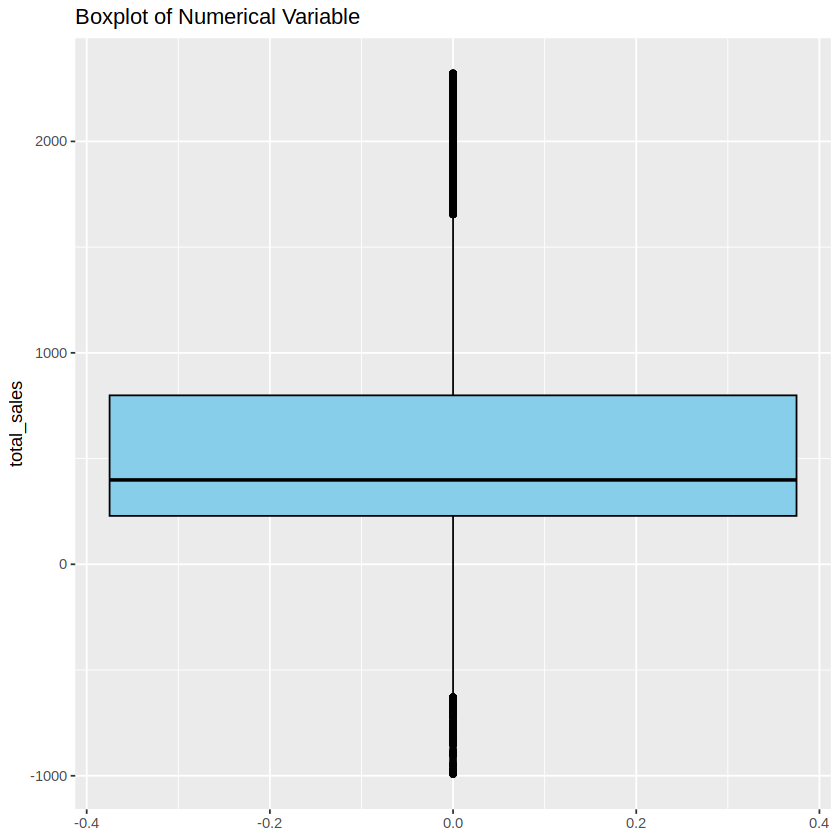

In [16]:
ggplot(cleaned_dataset, aes(y = total_sales)) +
  geom_boxplot(fill = "skyblue", color = "black") +
  labs(title = "Boxplot of Numerical Variable")

## Descriptive Analytics

In [17]:
summary(cleaned_dataset$shop_id)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   22.00   31.00   33.15   48.00   59.00 

In [18]:
summary(cleaned_dataset$total_sales)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -993.0   229.0   399.0   597.6   799.0  2322.0 

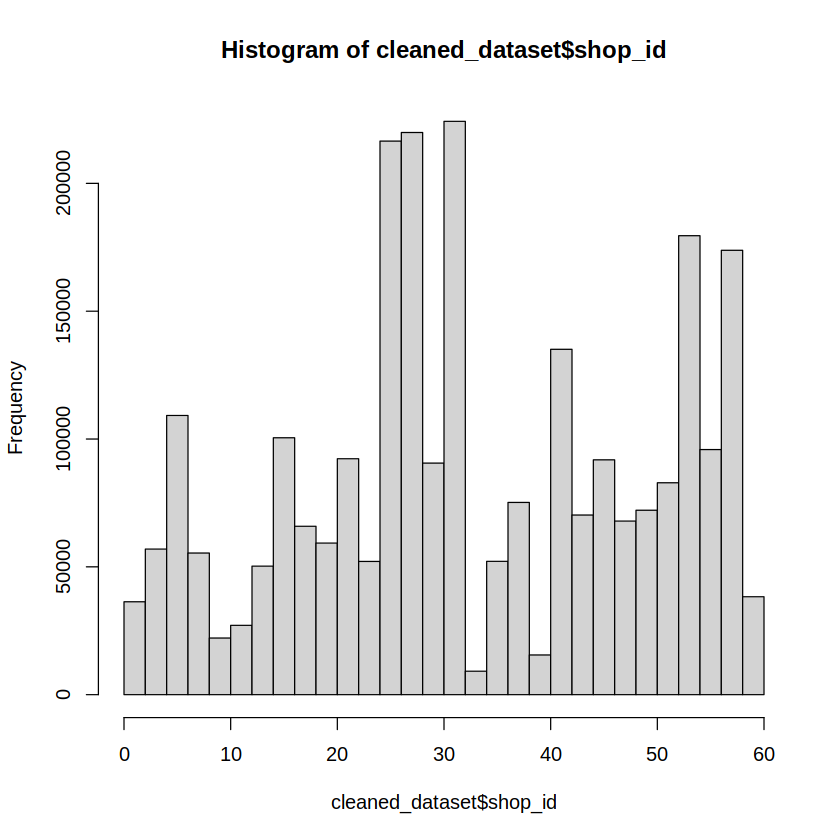

In [19]:
hist(cleaned_dataset$shop_id)

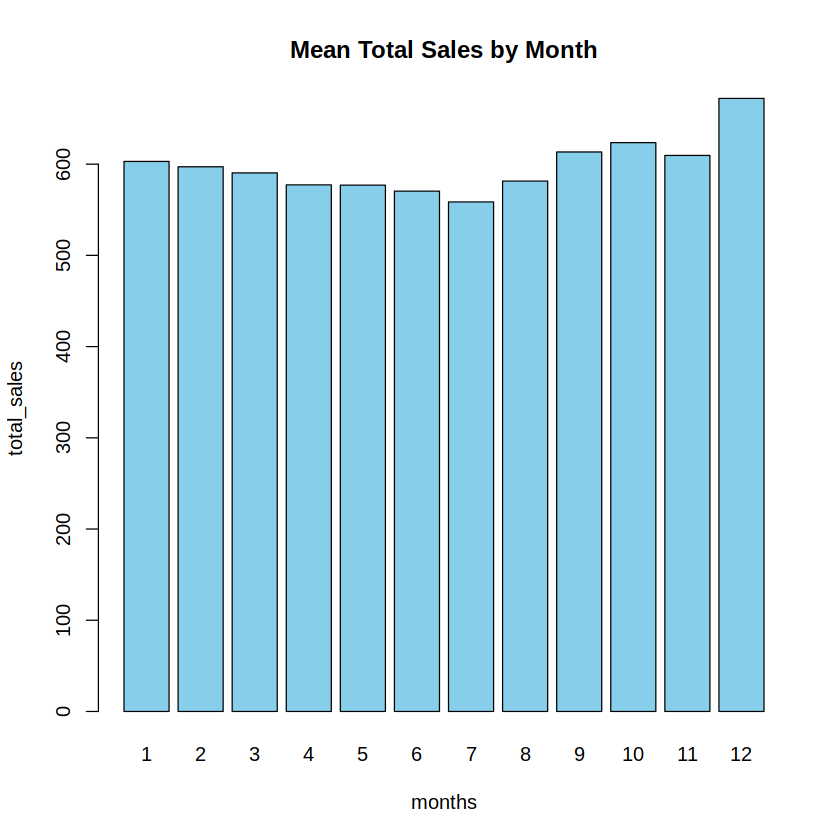

In [20]:
mean_y <- tapply(cleaned_dataset$total_sales, cleaned_dataset$month, mean)

barplot(mean_y, main = "Mean Total Sales by Month", 
        xlab = "months", ylab = "total_sales", col = "skyblue")

In [21]:
nrow(subset_data)

[1] 2638592

## Machine Learning

## 1. Random Forest

In [22]:
library(randomForest)
library(doParallel)

num_cores <- 10
cl <- makeCluster(num_cores)
registerDoParallel(cl)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [23]:
train_index <- sample(1:nrow(subset_data),0.8*nrow(subset_data))
train_set <- subset_data[train_index,]
test_set <- subset_data[-train_index,]

# train_set$year <- as.numeric(train_set$year)
# train_set$month <- as.numeric(train_set$month)
# test_set$year <- as.numeric(test_set$year)
# test_set$month <- as.numeric(test_set$month)

subset_indices <- sample(1:nrow(train_set), 300000)
subset_data <- train_set[subset_indices, ]


subset_index <- sample(1:nrow(test_set),1000)
subset_test <- test_set[subset_index, ]

# boxplot(monthly_sales$total_sales, main = "Boxplot before Removing Outliers")

# boxplot(subset_data$total_sales, main = "Boxplot after Removing Outliers")

In [24]:
predictor_variable <- as.matrix(subset_data[,c("year","month","day","shop_id","item_id")])
test_predictor <- as.matrix(subset_test[,c("year","month","day","shop_id","item_id")])
target_test <- as.matrix(subset_test$total_sales)
target_variable <- as.matrix(subset_data$total_sales)

In [26]:
rf_model <- randomForest(x=subset_data[,c("year","month","day","shop_id","item_id")],y=subset_data$total_sales,ntrees=5,cluster=cl)

In [29]:
predictions <- predict(rf_model, newdata = test_predictor)
rmse <- sqrt(mean((predictions - target_test)^2))
rmse

[1] 463.1924

## 2. ranger

In [25]:
library(ranger)


Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance




In [26]:
rf_model_parallel <- ranger(x=predictor_variable,y=target_variable,num.tree=1000,max.depth=100,num.threads=detectCores())

In [27]:
predictions <- predict(rf_model_parallel, data = test_predictor)$predictions
rmse <- sqrt(mean((target_test - predictions)^2))
print(paste("RMSE using ranger library (randomForest): ",rmse))

[1] "RMSE using ranger library (randomForest):  402.37725270585"


In [29]:
trees = c(100,400,500)
depths = c(20,50,70,100)
for(tree in trees){
    for (depth in depths){
        rf_model_parallel <- ranger(x=predictor_variable,y=target_variable,num.tree=tree,max.depth=depth,num.threads=detectCores())
        predictions <- predict(rf_model_parallel, data = test_predictor)$predictions
        rmse <- sqrt(mean((target_test - predictions)^2))
        print(paste("RMSE using ranger library (randomForest) with number of trees ",tree," and depth ",depth," : ",rmse))
    }
}

[1] "RMSE using ranger library (randomForest) with number of trees  100  and depth  20  :  415.321841431599"
[1] "RMSE using ranger library (randomForest) with number of trees  100  and depth  50  :  404.235540919602"
[1] "RMSE using ranger library (randomForest) with number of trees  100  and depth  70  :  405.026895575782"
[1] "RMSE using ranger library (randomForest) with number of trees  100  and depth  100  :  404.217087468705"
[1] "RMSE using ranger library (randomForest) with number of trees  400  and depth  20  :  415.239843852667"
[1] "RMSE using ranger library (randomForest) with number of trees  400  and depth  50  :  403.81459707779"
[1] "RMSE using ranger library (randomForest) with number of trees  400  and depth  70  :  403.567320492724"
[1] "RMSE using ranger library (randomForest) with number of trees  400  and depth  100  :  404.845585833223"
[1] "RMSE using ranger library (randomForest) with number of trees  500  and depth  20  :  415.37680712673"
[1] "RMSE using ran

## Gradient Boosting

In [31]:
library(xgboost)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [47]:
xgb_params <- list(
    objective="reg:squarederror",
    eta=0.3,
    max_depth = 20,
    subsample=0.8,
    colsample_bytree=0.7
)
xgb_model <- xgboost(data=predictor_variable,label=target_variable,params=xgb_params,nrounds=100,nthread=detectCores())

[1]	train-rmse:580.276856 
[2]	train-rmse:439.044224 
[3]	train-rmse:381.614368 
[4]	train-rmse:309.395651 
[5]	train-rmse:259.732565 
[6]	train-rmse:245.465123 
[7]	train-rmse:215.829280 
[8]	train-rmse:195.961745 
[9]	train-rmse:179.918026 
[10]	train-rmse:168.621781 
[11]	train-rmse:160.734685 
[12]	train-rmse:154.220380 
[13]	train-rmse:153.787308 
[14]	train-rmse:153.569405 
[15]	train-rmse:148.388932 
[16]	train-rmse:147.293529 
[17]	train-rmse:141.203035 
[18]	train-rmse:137.295343 
[19]	train-rmse:133.114440 
[20]	train-rmse:132.782102 
[21]	train-rmse:130.077129 
[22]	train-rmse:128.405897 
[23]	train-rmse:125.350113 
[24]	train-rmse:123.527465 
[25]	train-rmse:121.563319 
[26]	train-rmse:119.801493 
[27]	train-rmse:119.080351 
[28]	train-rmse:117.739125 
[29]	train-rmse:117.701229 
[30]	train-rmse:117.598393 
[31]	train-rmse:115.352635 
[32]	train-rmse:113.191434 
[33]	train-rmse:113.171877 
[34]	train-rmse:112.558939 
[35]	train-rmse:112.060078 
[36]	train-rmse:111.237725 
[

In [51]:
predictions <- predict(xgb_model, newdata = test_predictor)
rmse <- sqrt(mean((target_test - predictions)^2))
print(paste("RMSE using ranger library (XGBoost): ",rmse))

[1] "RMSE using ranger library (XGBoost):  203.537685192535"


In [32]:
depths = c(10,20,30,40)
for(depth in depths){
    xgb_params <- list(
        objective="reg:squarederror",
        eta=0.3,
        max_depth = depth,
        subsample=0.8,
        colsample_bytree=0.7
    )
    xgb_model <- xgboost(data=predictor_variable,label=target_variable,params=xgb_params,nrounds=100,nthread=detectCores())
    predictions <- predict(xgb_model, newdata = test_predictor)
    rmse <- sqrt(mean((target_test - predictions)^2))
    print(paste("RMSE using ranger library (XGBoost) with depth ",depth," : ",rmse))
}

[1]	train-rmse:657.958642 
[2]	train-rmse:585.322740 
[3]	train-rmse:493.747857 
[4]	train-rmse:470.655086 
[5]	train-rmse:458.494258 
[6]	train-rmse:452.298808 
[7]	train-rmse:417.053086 
[8]	train-rmse:393.288021 
[9]	train-rmse:381.129846 
[10]	train-rmse:366.514404 
[11]	train-rmse:365.986860 
[12]	train-rmse:365.395567 
[13]	train-rmse:358.950311 
[14]	train-rmse:348.416864 
[15]	train-rmse:340.293463 
[16]	train-rmse:339.937942 
[17]	train-rmse:339.724962 
[18]	train-rmse:334.616345 
[19]	train-rmse:328.166306 
[20]	train-rmse:322.322060 
[21]	train-rmse:314.572251 
[22]	train-rmse:311.387257 
[23]	train-rmse:311.267572 
[24]	train-rmse:310.953095 
[25]	train-rmse:308.324988 
[26]	train-rmse:307.145137 
[27]	train-rmse:307.080606 
[28]	train-rmse:307.042655 
[29]	train-rmse:307.011371 
[30]	train-rmse:306.661842 
[31]	train-rmse:303.612177 
[32]	train-rmse:303.543476 
[33]	train-rmse:300.101743 
[34]	train-rmse:298.137627 
[35]	train-rmse:297.817470 
[36]	train-rmse:296.113948 
[

## Support Vector Machines (SVM)

In [52]:
library(e1071)

In [53]:
svm_model <- svm(x = predictor_variable, y = target_variable)

In [54]:
predictions <- predict(svm_model, newdata = test_predictor)
rmse <- sqrt(mean((predictions - target_test)^2))
rmse

[1] 497.6698

In [55]:
ss_total <- sum((target_test - mean(target_test))^2)
ss_residual <- sum((target_test - predictions)^2)
r_squared <- 1 - (ss_residual / ss_total)

In [56]:
r_squared

[1] 0.0524994

## h2o (random forest) grid search

In [33]:
h2o.no_progress()
h2o.init(max_mem_size = "5g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpP96qjF/file1d7030274a31/h2o_saikiranbattula_started_from_r.out
    /tmp/RtmpP96qjF/file1d703ffcbd63/h2o_saikiranbattula_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 90 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.44.0.3 
    H2O cluster version age:    3 months and 27 days 
    H2O cluster name:           H2O_started_from_R_saikiranbattula_wsx527 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.44 GB 
    H2O cluster total cores:    24 
    H2O cluster allowed cores:  24 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is (3 months and 27 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html”


In [34]:
train_h2o <- as.h2o(subset_data)

In [35]:
n_features <- 5

hyper_grid <- list(
  mtries = pmax(1, floor(n_features * c(.05, .15, .25, .333, .4))),
  min_rows = c(1, 3, 5, 10),
  max_depth = c(10, 20, 30),
  sample_rate = c(.55, .632, .70, .80)
)

search_criteria <- list(
  strategy = "RandomDiscrete",
  stopping_metric = "mse",
  stopping_tolerance = 0.001,   
  stopping_rounds = 10,        
  max_runtime_secs = 60*5      
)

random_grid <- h2o.grid(
  algorithm = "randomForest",
  grid_id = "rf_random_grid",
  x = predictor_variable,
  y = target_variable,
  training_frame = train_h2o,
  hyper_params = hyper_grid,
  ntrees = n_features * 10,
  seed = 123,
  stopping_metric = "RMSE",
  stopping_rounds = 10,          
  stopping_tolerance = 0.005,   
  search_criteria = search_criteria
)

random_grid_perf <- h2o.getGrid(
  grid_id = "rf_random_grid",
  sort_by = "mse",
  decreasing = FALSE
)
print(random_grid_perf)

ERROR: Error in base::`||`(x, y): 'length = 300000' in coercion to 'logical(1)'
